<a href="https://colab.research.google.com/github/Amirali-Khatib/Machine_Learning/blob/main/Amazon_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bonus Project**: Amazon consumers’ reviews sentiment analysis
**Students Name:** Amirali Khatib  &  Sina Omrani

**Professor Name:** Dr. Mohammadreza-R Akbarzadeh-T

# **Preface**

**Sentiment analysis** has been considered as one of the major applications of **text classification** in field of Natural Language Processing(**NLP**). In this project we are aimed to do some data manipulation on text and fed its ecoded form to the models and evaluate their performance.

Here is the summary of the steps we should take through the project:

* **Text cleaning**: convert the all the letters to their lower-case form, omitting stop-words and etc.
* **Text vectorization**: using **Fasttext** pre-trained **Word2Vec** word embedding model. We have also used Priciple Component analysis (**PCA**) in order to reduce the dimension of the input features from 300 to 100 and train the below mentioned models separately on the reduced form of data.
* **Training & Evaluation**: we have trained Stochastic gradient descent, Gaussian Naive bayes and Support vector machine (with RBF & Linear kernel).




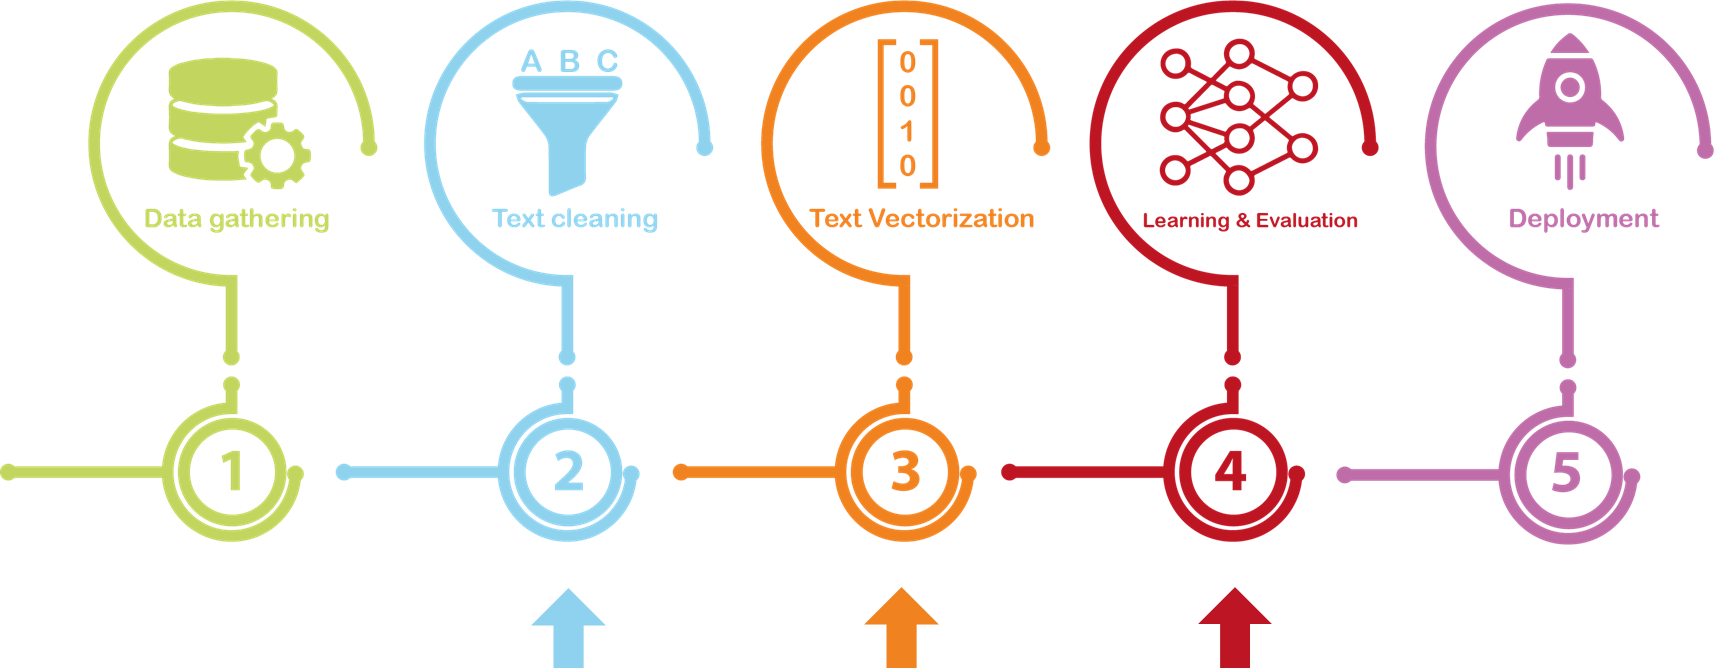



# **Import required libraries**

In [1]:
# For data manipulation
import numpy as np
import pandas as pd
# For directory management
from google.colab import drive
import os
# For data visualization
import seaborn as sns
# For text pre-processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
# For saving Word2Vec vectorized feature for each text
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Amazon dataset**

We are given a dataset which is about Amazon Consumers' reviews. It consists more than 500K user comments. Regarding volume of our dataset, it is computationally time consuming to do sentiment classification on whole dataset. Hence, We have uniformly taken 120K samples (40K Negative - 40K Positive - 40K Neutral) from the dataset to build balanced sampled dataset.

In [ ]:
# current directory status
!ls

drive  sample_data


In [ ]:
# to copy dataset from google drive storage to current colab working directory
! cp '/content/drive/MyDrive/Natural Language Processing/AMNZ2.zip' .

In [ ]:
!ls

AMNZ2.zip  drive  sample_data


In [ ]:
! unzip 'AMNZ2.zip'

Archive:  AMNZ2.zip
  inflating: Reviews.csv             


In [ ]:
!ls

AMNZ2.zip  drive  Reviews.csv  sample_data


In [ ]:
df = pd.read_csv('Reviews.csv')

In [ ]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
df1 = df
df1 = df1[pd.isna(df1['Summary']) == False]
df1 = df1[['Text', 'Summary', 'Score', 'Time']]
# Add polarity column
df1['Polarity'] = ["Positive" if df1.iloc[i]['Score'] >= 4 else "Negative" if df1.iloc[i]['Score'] <= 2 else "Neutral"  for i in range(len(df1))]
# Sampling 120K comments
df1pos = df1[df1['Polarity'] == 'Positive'].head(40000)
df1neg = df1[df1['Polarity'] == 'Negative'].head(40000)
df1neu = df1[df1['Polarity'] == 'Neutral'].head(40000)
df1 = pd.concat([df1pos, df1neg, df1neu])
df1.head(2)

,Text,Summary,Score,Time,Polarity
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,1303862400,Positive
2,This is a confection that has been around a fe...,"""Delight"" says it all",4,1219017600,Positive


In [ ]:
# Shuffling dataset
df1 = df1.sample(frac=1, random_state=42)

# **Pre-processing**

In pre-processing step, We have done these tasks below:

* Convert all the letters to lower case form
* Tokenize all comments into words
* Remove punctuation from tokenized list for each comment
* Remove English stopwords from tokenized list for each comment
* Lemmatize every left tokens in each comment's tokenized list

In [ ]:
def preprocess_text(text):

  # Convert text to lowercase
  text = text.lower()

  # Tokenize the text into words
  tokens = word_tokenize(text)

  # Remove punctuation
  tokens = [tkn for tkn in tokens if tkn.isalnum() or tkn.isspace()]

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [tkn for tkn in tokens if tkn not in stop_words]

  # Lemmatize words
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(tkn) for tkn in tokens]

  return tokens

In [ ]:
df1['T_S'] = [df1.iloc[i]['Summary'] +'. '+ df1.iloc[i]['Text'] for i in range(len(df1))]

In [ ]:
df1['text_tkns'] = [preprocess_text(df1.iloc[i]['T_S']) for i in range(len(df1))]

In [ ]:
df1.head()

,Text,Summary,Score,Time,Polarity,T_S,text_tkns
219687,"I know this is good for me, and low in calorie...",Cardboard...,2,1218931200,Negative,"Cardboard.... I know this is good for me, and ...","[cardboard, know, good, low, etc, like, eating..."
188032,"Tea is great, but it the description is FALSE ...",STILL FALSE ADVERTISING,2,1320192000,Negative,"STILL FALSE ADVERTISING. Tea is great, but it ...","[still, false, advertising, tea, great, descri..."
93784,Why is this cereal $16 a box??? Is there somet...,price?,1,1249603200,Negative,price?. Why is this cereal $16 a box??? Is the...,"[price, cereal, 16, box, something, missing, k..."
9422,We've tried many of the K-cups that are availa...,One of the best K-cups,5,1290470400,Positive,One of the best K-cups. We've tried many of th...,"[one, best, tried, many, available, top, prefe..."
38547,"We use syrup for homemade coffee drinks, and t...",Lifesavers and at a great price,5,1323734400,Positive,Lifesavers and at a great price. We use syrup ...,"[lifesaver, great, price, use, syrup, homemade..."


# **Vectorization**

In this step we should encode the tokenized list. We have decided to vectorize in 3 following ways:

* **Bag of words**: Due to degree of sparsity of this vectorization  and the volume of our dataset, the Colab RAM got crashed.

* **TF-IDF**: Due to degree of sparsity of this vectorization  and the volume of our dataset, the Colab RAM got crashed.

* **World2Vec**: Due to the importance of dense representation of comments, We use Word2Vec representation that can define semantic relationship between words in each word.

**Note**: The number of unique tokens is some thing about 1 Million and we are given 120K comments. As a deduction It is understandable why the Colab RAM storage got crashed when it encounterd **120K by 1 Million** matrix.

## **Example for BOW**

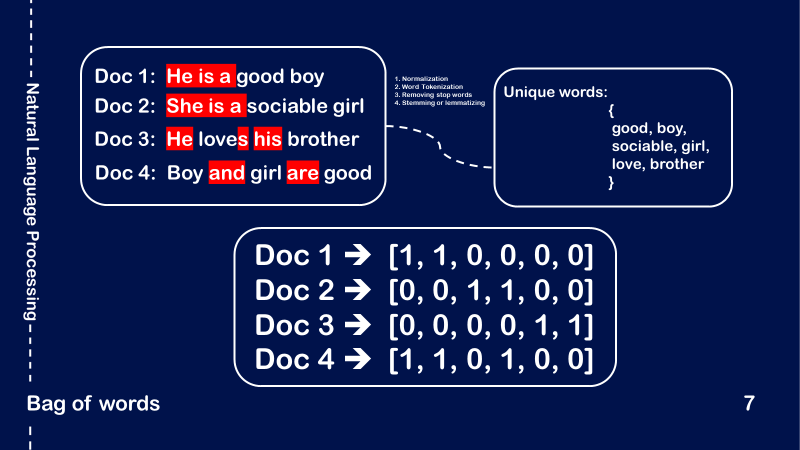

In this example we are given 4 documents, but in our real-world dataset we have 120K documents that is why our RAM storage is going to be crashed.

## **Example for TF-IDF**

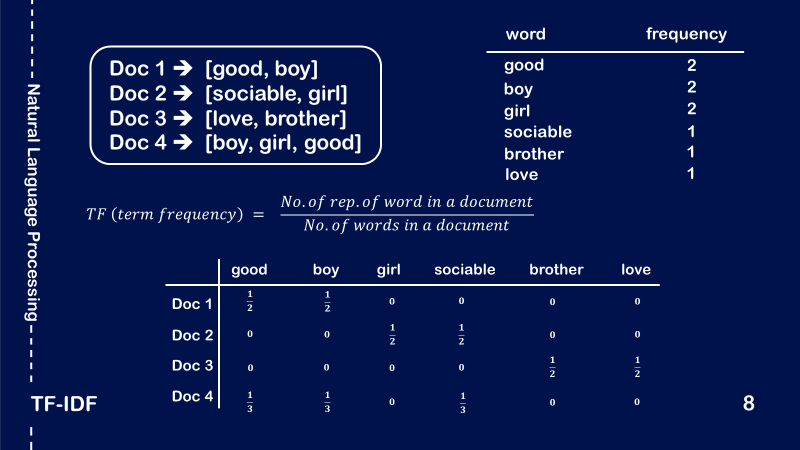

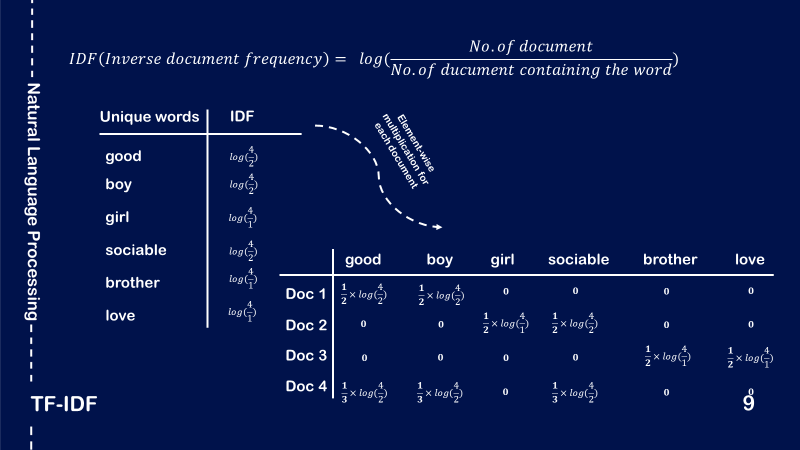

**TF-IDF** vectorization would have the same shape as **BOW** vectorization method.

## **Example for Word2Vec**

Word2Vec is a language model used for word representation and word similarity analysis. It is based on neural network architectures and aims to capture semantic relationships between words. It represents words as dense vectors in a continuous vector space, where similar words are closer to each other. Word2Vec models are trained on large corpora and learn to predict the context of words, resulting in word embeddings that encode semantic information. These embeddings can be utilized for tasks such as word analogy, text classification, and information retrieval. Word2Vec has become a widely used tool in natural language processing due to its ability to capture meaningful word representations.

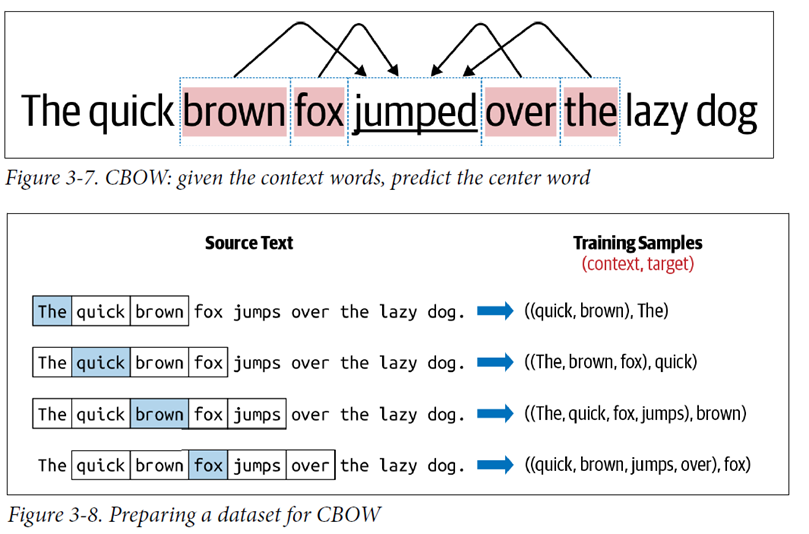

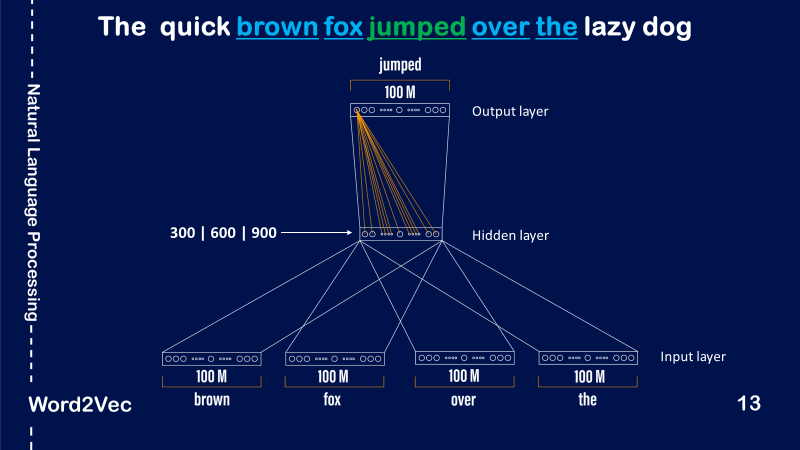

Each word is represented as (300,1) vector. Each tokens list are represented as (300,1) vector by taking the element-wise average among the (300,1) vectors of the tokens in the related list.

In [ ]:
! pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393407 sha256=1dcb6e265ad8d9f2e1a8a01272d14f764cabef89fc93da773a782ee35ca3c2fe
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
type(ft)

fasttext.FastText._FastText

In [ ]:
def FastText_vec_builder(pre_train, tokns):

  l = []

  if len(tokns) == 0:
    l.append(300 * [0])

  else:
    for w in tokns:
      try:
        l.append(list(pre_train[w]))
      except:
        # OOV situation !
        l.append(list(np.random.uniform(low=-0.25, high=0.25,size=300)))

    l = np.array(l)
    l = list(np.mean(l, axis = 0))

  return l

In [ ]:
df1.head(2)

,Text,Summary,Score,Time,Polarity,T_S,text_tkns
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,1303862400,Positive,Good Quality Dog Food. I have bought several o...,"[good, quality, dog, food, bought, several, vi..."
2,This is a confection that has been around a fe...,"""Delight"" says it all",4,1219017600,Positive,"""Delight"" says it all. This is a confection th...","[delight, say, confection, around, century, li..."


In [ ]:
word2vec_Vec = np.array([FastText_vec_builder(ft, df1.iloc[i]['text_tkns']) for i in range(len(df1))])
print(f'FastText dim -> {np.shape(word2vec_Vec)}')

FastText dim -> (120000, 300)


we have stored the word2vec representation of comments in plickle file.

In [ ]:
import pickle
with open('W2V.pickle', 'wb') as handle:
  pickle.dump(word2vec_Vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
! cp '/content/W2V.pickle' '/content/drive/MyDrive/Linear Algebra'

Open **`W2V.pickle`** file

In [ ]:
! cp '/content/drive/MyDrive/Linear Algebra/W2V.pickle' .

In [ ]:
import pickle
with open('W2V.pickle',mode='rb') as data:
  w2v = pickle.load(data)

In [ ]:
type(w2v)

numpy.ndarray

In [ ]:
w2v.shape

(120000, 300)

In [ ]:
df1['Polarity_int'] = [(int(2) if df1.iloc[i]['Polarity'] == "Positive" else int(1) if df1.iloc[i]['Polarity'] == "Neutural" else int(0)) for i in range(len(df1))]

In [ ]:
np.array(df1['Polarity_int']).shape

(120000,)

In [ ]:
x,y = w2v, np.array(df1['Polarity_int'])

# **Training & Evaluation**

## **Stochastic Gradient Descent**

Let's consider a multiclass classification problem with
$C$ classes. Given a training dataset with
$N$ examples, denoted as ($x_{i}, y_{i}$) where $x_{i}$ represents the input features and $y_{i}$ represents the true class label for example $i$.

We want to find the optimal parameters, denoted as $\theta$, for the classification model. The model computes the class probabilities using a softmax function:

$P(y=c | x; \theta) = \frac{e^{f_c(x; \theta)}}{\sum_{j=1}^{C} e^{f_j(x; \theta)}}$

where ... is the score function for class $c$ computed by the model with parameters $\theta$.

The loss function used for multiclass classification is often the cross-entropy loss. The overall loss function $L(\theta)$
can be defined as the average loss over all training examples:


$L(\theta) = -\frac{1}{N} \sum_{i=1}^{N} \log(P(y_i | x_i; \theta))$

The goal is to minimize this loss function by updating the parameters $\theta$ using SGD.

At each iteration of SGD, a mini-batch of training examples, denoted as $B$, is randomly sampled from the training dataset. Let $n$ represent the size of the mini-batch.

The parameters are updated iteratively based on the gradients of the loss function computed on the mini-batch as follows:

$\theta_{t+1} = \theta_t - \eta \frac{1}{n} \sum_{i \in B} \nabla L(\theta_t, x_i, y_i)$

The process continues for a fixed number of iterations or until a convergence criterion is met.





In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
model = SGDClassifier()
# learning_rate = 0.0001
model.fit(x_train, y_train)

SGDClassifier()

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7985416666666667


## **Gaussian Naive Bayes**

We plot 1 of 300 features of word2vec representation as a sample to see how much it looks like gaussian distribution

<Axes: ylabel='Count'>

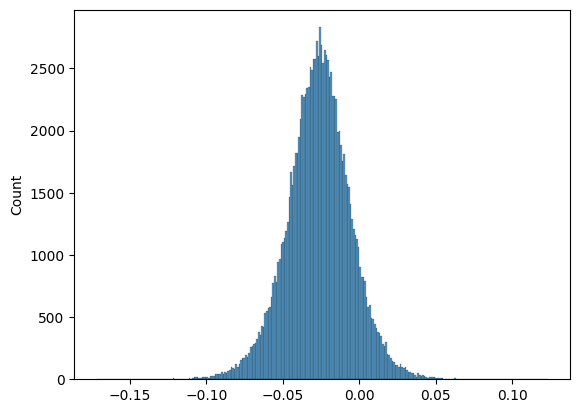

In [ ]:
sns.histplot(w2v[:,299])

consider a multiclass classification problem with $C$ classes and a set of continuous features  $x=(x_{1}, x_{2},...,x_{n})$ for a given input example.

The Gaussian Naive Bayes classifier assumes that the features within each class follow a Gaussian (normal) distribution. It calculates the posterior probability $P(C_{k}∣x)$ for each class $C_{k}$ using Bayes' theorem:

$P(C_k | x) = \frac{P(C_k) \cdot P(x | C_k)}{P(x)}$

where $P(C_{k})$ is the prior probability of class $C_{k}$, $P(x∣C_{k})$ is the likelihood of observing the features $x$ given class $C_{K}$, and $P(x)$ is the evidence probability.

Under the assumption of feature independence (naive assumption), we can simplify the likelihood term as follows:

$P(x | C_k) = P(x_1 | C_k) \cdot P(x_2 | C_k) \cdot \ldots \cdot P(x_n | C_k)$

Each $P(x_{i}∣C_{k})$ is modeled as a Gaussian distribution, characterized by its mean $\mu_{ik}$ and variance $\sigma_{ik}^{2}$ for feature $x_{i}$ in class $C_{k}$.

To classify a new example $x_{new}$, we calculate the posterior probability $P(C_{k}|x_{new})$ for each class $C_{k}$ and assign the example to the class with the highest probability.

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [ ]:
y_pred = gnb.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.687375

## **support vector machine**

The basic idea of SVM is to find the optimal hyperplane that maximally separates two classes in a dataset. Let's assume we have a binary classification problem with two classes, labeled as -1 and +1. Given a training dataset $(x_{i}, y_{i})$, where $x_{i}$ is the i-th input vector and $y_{i}$ is its corresponding class label, the goal of SVM is to find a hyperplane defined by the weight vector $w$ and bias term $b$ that separates the two classes.

The hyperplane equation can be defined as:

$W\cdot X + b = 0$

where $\cdot$ denotes the dot product between vectors $W$ and $X$.

To handle non-linearly separable data, SVM introduces the concept of slack variables $ξ_{i}$ to allow for some misclassifications. The optimization problem of SVM can be formulated as follows:

$ \min_{\mathbf{w}, b, \boldsymbol{\xi}} \left( \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{N} \xi_i \right)$

subject to:

$y_i(\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1 - \xi_i, \quad \forall i $

$ \xi_i \geq 0, \quad \forall i $

Here, $N$ represents the total number of training samples, and $C$ is a regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification errors. The term $\frac{1}{2}\|\mathbf{w}\|^{2}$ represents the regularization term that encourages the weights to be small, ensuring a larger margin.

The objective function aims to minimize the norm of the weight vector while penalizing misclassifications through the slack variables $\xi_{.}$. The constraints ensure that all training samples lie on the correct side of the margin or within a margin width of 1(controlled by $\xi_{i}$).


### **Linear kernel**

In [ ]:
SVM = svm.SVC(kernel='linear')
SVM.fit(x_train, y_train)

# Make predictions
y_pred = SVM.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8258333333333333


### **Radial Basis Function kernel**

In [ ]:
SVM = svm.SVC(kernel='rbf')
SVM.fit(x_train, y_train)

# Make predictions
y_pred = SVM.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.850875


## **Dimensionality reduction using PCA**

Principal Component Analysis (PCA) is a dimensionality reduction technique that aims to find a lower-dimensional representation of a dataset while preserving the maximum amount of variance. Given a dataset with $N$ samples and $D$ features, the goal of PCA is to find a set of orthogonal vectors, called principal components, that capture the most significant information in the data.

Let X be an $N×D$ matrix representing the dataset, where each row corresponds to a sample and each column represents a feature. The steps involved in performing PCA are as follows:

1. **Data Standardization**: Standardize the data by subtracting the mean and dividing by the standard deviation along each feature. This ensures that all features have zero mean and unit variance.

2. **Covariance Matrix**: Compute the covariance matrix $C$ of the standardized data, given by:    $\mathbf{C} = \frac{1}{N} \mathbf{X}^T \mathbf{X}$

3. **Eigenvalue Decomposition**: Perform the eigenvalue decomposition of the covariance matrix to obtain its eigenvectors and eigenvalues. Let V be an $D×D$ matrix whose columns are the eigenvectors, and $λ$ be a diagonal matrix containing the eigenvalues. The eigenvalue decomposition is given by: $\mathbf{C} = \mathbf{V} \boldsymbol{\lambda} \mathbf{V}^T$

4. **Selection of Principal Components**: Sort the eigenvalues in descending order and select the top $K$ eigenvectors corresponding to the largest eigenvalues. These eigenvectors form the $K$ principal components.

5. **Projection**: Project the standardized data onto the
$K$ principal components to obtain the lower-dimensional representation. The projection of a data point $x$ onto the principal components is given by: $\mathbf{Z} = \mathbf{X} \mathbf{V}_K$


In [ ]:
# Create a PCA instance
pca = PCA(n_components=100)

# Fit the data to the PCA model
pca.fit(w2v)

# Transform the data to its principal components
x_pca = pca.transform(w2v)
x_pca.shape

(120000, 100)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

### **Train the previous models on dimensionally reduced data**

Stochastic Gradient descent

In [ ]:
model = SGDClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6665


Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.664625


Support Vector Machine

linear kernel

In [ ]:
SVM = svm.SVC(kernel='linear')
SVM.fit(x_train, y_train)

# Make predictions
y_pred = SVM.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6665


rbf kernel

In [ ]:
SVM = svm.SVC(kernel='rbf')
SVM.fit(x_train, y_train)

# Make predictions
y_pred = SVM.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.665875


# **Conclusion**

In [4]:
Report = {'Dim': 4*['300']+4*['100'],
          'Model': 2*['SGD', 'GNB', 'SVM_Lin', 'SVM_Rbf'],
          'Accuracy': [0.7985416666666667, 0.687375, 0.8258333333333333, 0.850875,
                       0.6665, 0.664625, 0.6665, 0.665875]}
Report = pd.DataFrame(Report)
Report

,Dim,Model,Accuracy
0,300,SGD,0.798542
1,300,GNB,0.687375
2,300,SVM_Lin,0.825833
3,300,SVM_Rbf,0.850875
4,100,SGD,0.666500
5,100,GNB,0.664625
6,100,SVM_Lin,0.666500
7,100,SVM_Rbf,0.665875


<Axes: xlabel='Model', ylabel='Accuracy'>

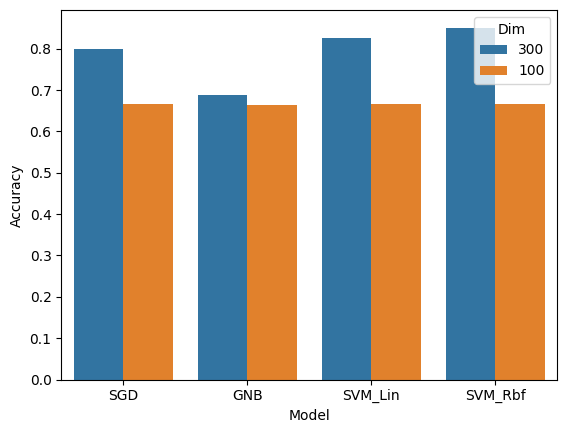

In [5]:
sns.barplot(x='Model',y='Accuracy',data=Report,hue='Dim')

We can conclude that compressing data using Algebraic reduction method cause the considerable decrease in performance metrics of the models. But it can be useful when we want to speed up the training procedure and the amount of decrease that caused by reduction isn't too high.